In [ ]:
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,accuracy_score,recall_score,confusion_matrix

## Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
# Mean normalization
mean = np.mean(x_train, axis=0)
x_train -= mean
x_test -= mean

169009152/169001437 [==============================] - 2s 0us/step


In [ ]:
print(x_train.shape[-3:],y_train.shape)

(32, 32, 3) (50000, 100)


## Building the Model

In [ ]:
def create_model():
    model = Sequential()
    weight_decay = 0.001

    model.add(Conv2D(64, (3, 3), padding='same',
                      input_shape=x_train.shape[-3:]))
    model.add(Activation('elu'))     #using relu (acc 34%), elu (acc 45%), leaky relu (acc 40)

    model.add(Conv2D(64, (3, 3), padding='same',))
    model.add(Activation('elu'))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('elu'))

    model.add(Dense(100))
    model.add(Activation('softmax'))
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0

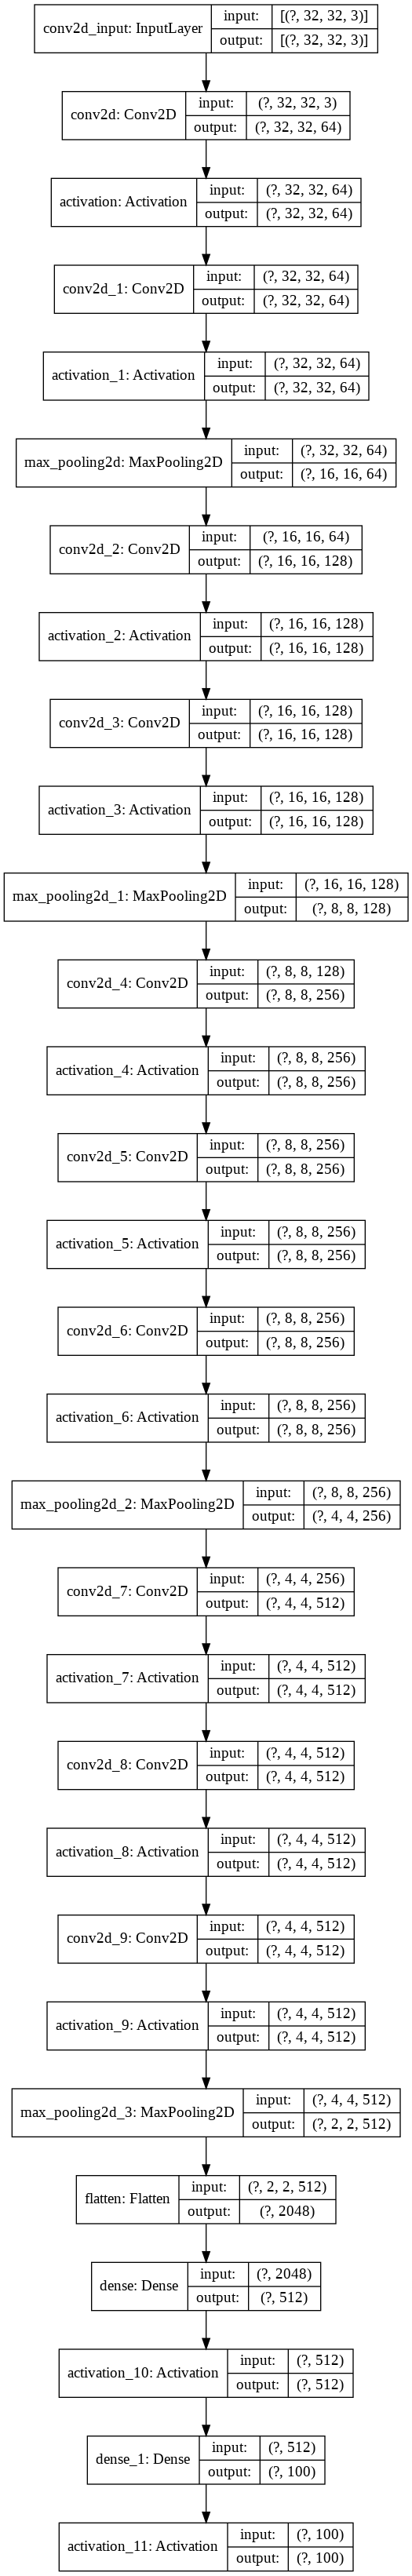

In [ ]:
model = create_model()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning rate 0.035 gave best results with decay 1e-5, accuracy dropped when lr/decay was increased
sgd = optimizers.SGD(lr=0.035, decay=1e-5,momentum=0.8) #epochs=15
adam = optimizers.Adam(lr=0.001, decay = 1e-3) #epochs=80
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=5,mode='max')
checkpoint_path = "VGGNet16_SGD_NoRegularization"
best_model = ModelCheckpoint(filepath = checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')

# batch size to 128 for best accuracy, it decreases if batch size is increased
history = model.fit(x_train, y_train,
                    batch_size= 128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping,best_model],verbose=2)

Epoch 1/15
391/391 - 24s - loss: 3.5968 - accuracy: 0.1602 - val_loss: 2.9336 - val_accuracy: 0.2785
Epoch 2/15
391/391 - 23s - loss: 2.6266 - accuracy: 0.3352 - val_loss: 2.4198 - val_accuracy: 0.3830
Epoch 3/15
391/391 - 23s - loss: 2.0850 - accuracy: 0.4514 - val_loss: 2.2976 - val_accuracy: 0.4132
Epoch 4/15
391/391 - 23s - loss: 1.6549 - accuracy: 0.5464 - val_loss: 2.2167 - val_accuracy: 0.4453
Epoch 5/15
391/391 - 23s - loss: 1.2378 - accuracy: 0.6476 - val_loss: 2.3626 - val_accuracy: 0.4504
Epoch 6/15
391/391 - 23s - loss: 0.9002 - accuracy: 0.7330 - val_loss: 2.6803 - val_accuracy: 0.4355
Epoch 7/15
391/391 - 23s - loss: 0.7327 - accuracy: 0.7805 - val_loss: 2.9446 - val_accuracy: 0.4372
Epoch 8/15
391/391 - 23s - loss: 0.7060 - accuracy: 0.7907 - val_loss: 3.0947 - val_accuracy: 0.4188
Epoch 9/15
391/391 - 23s - loss: 0.7518 - accuracy: 0.7815 - val_loss: 3.1835 - val_accuracy: 0.4144
Epoch 10/15
391/391 - 23s - loss: 0.8242 - accuracy: 0.7660 - val_loss: 3.1643 - val_accura

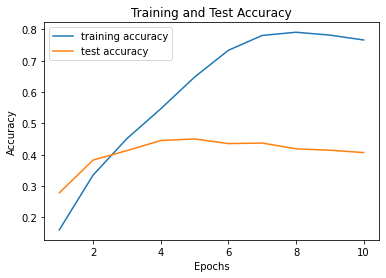

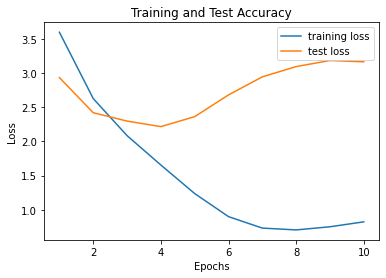

In [ ]:
#plot Accuracy vs epochs
train_metrics = history.history['accuracy']
val_metrics = history.history['val_accuracy']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training accuracy", 'test accuracy'])
plt.show()
#plot Validaiton loss vs epochs
train_metrics = history.history['loss']
val_metrics = history.history['val_loss']
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss", 'test loss'])
plt.show()

In [ ]:
model = create_model()
# checkpoint_path = "../weights/VGGNet16_SGD_NoRegularization"
checkpoint_path = "VGGNet16_SGD_NoRegularization"
model.load_weights(checkpoint_path)
# loss,acc = model.evaluate(x_test,  y_test, verbose=2)
# print('Test Accuracy:', acc)
prediction = model.predict(x_test).argmax(-1)
cm = confusion_matrix(y_test.argmax(axis=1), prediction)
np.set_printoptions(threshold=5000)
print(cm)
precision = precision_score(y_test.argmax(axis=1), prediction, average='weighted')

accuracy= accuracy_score(y_test.argmax(axis=1), prediction)
recall= recall_score(y_test.argmax(axis=1), prediction, average='weighted')

print('precision:', precision)
print('accuracy:', accuracy)
print('recall:', recall)

[[74  2  0 ...  0  0  0]
 [ 1 64  0 ...  0  0  0]
 [ 0  0 35 ...  0  4  0]
 ...
 [ 0  0  3 ... 50  0  0]
 [ 1  0  9 ...  1 19  0]
 [ 0  0  2 ...  0  1 38]]
precision: 0.48476986128495364
accuracy: 0.4504
recall: 0.4504
